# Collaborative structural biology using machine learning and Jupyter notebook
##    Fergus Boyles and Fergus Imrie
##    *Department of Statistics, University of Oxford*

# But it runs on my machine!

This notebook was written in Python 3.6 using numpy version 1.14.5, pandas version 0.23.1, and scikit-learn version 0.19.1. Rather than provide a list of dependencies, hope you have the same versions, and pray that there are no conflicts between with your python installation, we're going to use the package manager Conda to set up an isolated python environment with exactly what we need. This has the twin benefits of not only ensuring you can run the code using exactly the same packages we used when writing it, but also ensures that any dependencies of our code can be installed without interfering with your default python installation.

# A Python environment for data science

* numpy: Matrix algebra and numerical methods.
* pandas: Data frames for manipulating and visualising data as tables.
* matplotlib: Everybody's favourite Python plotting library.
* seaborn: Statistical visualisation library built on matplotlib and pandas. Lots of high-level functions for data visualisation.
* scikit-learn (sklearn): Machine learning library. Today we'll use its implementations of logistic regression and random forest.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

sns.set(context='notebook', style='white', font_scale=1.8)

To keep this notebook as short and tidy as possible, I've written some helper functions for thinks like plotting and data processing. Check out the other files if you'd like to see how things are implemented.

In [3]:
import plotting

# Data exploration

_Load and look:_ Can directly load data from csv using pandas. Don't forget to look at your data!

In [4]:
all_data = pd.read_csv('../data/Data_3DSig.txt', sep=' ')
all_data.dropna(axis='index', how='any', inplace=True)
all_data.head()

,Target,Template,Target_Length,Template_Length,Contact_PPV,Contact_TP,Contact_P,Contact_All,Neff,SeqID,Label
0,d12asa_,d1yfsa2,328,237,4.65,2,43,101,2676,0.177,Fam
1,d12asa_,d1eova2,328,354,22.99,20,87,101,2676,0.223,Fam
2,d12asa_,d1b8aa2,328,336,22.22,20,90,101,2676,0.220,Fam
3,d12asa_,d1l0wa3,328,357,20.00,17,85,101,2676,0.235,Fam
4,d12asa_,d1z7ma1,328,312,1.27,1,79,101,2676,0.211,Fam


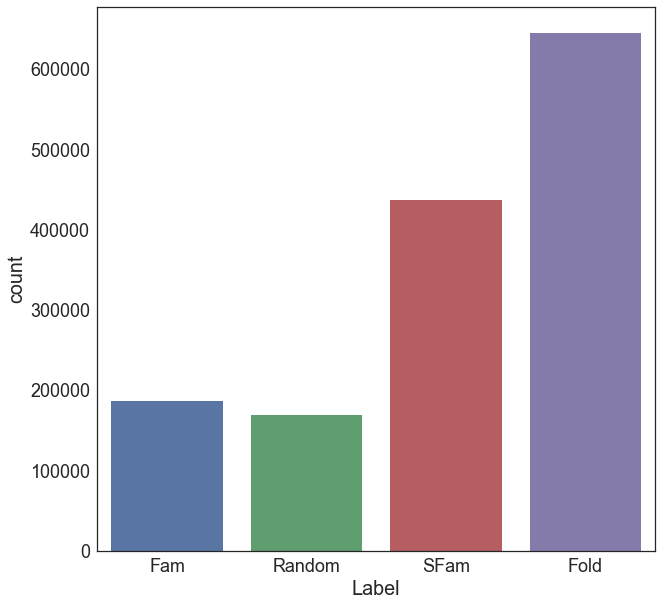

In [5]:
split = pd.read_csv('../data/Data_Split.txt', sep=' ', header=None)
split.columns = ['Protein', 'Split']

# Select target-template pairs where both proteins belong to the 'same family' cluster
targets = split[split['Split']=='FAMILY']['Protein']
data = all_data[(all_data['Target'].isin(targets)) & (all_data['Template'].isin(targets))].copy()

# Drop duplicated rows since we don't know which entry is correct
# Be sure to keep a record of which samples are dropped
duplicate_idx = data.duplicated(subset=['Template', 'Target'], keep=False)
duplicates = data.loc[duplicate_idx].sort_values(by=['Target', 'Template'])
data.drop_duplicates(subset=['Template', 'Target'], keep=False, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.countplot(data=data, x='Label', ax=ax)

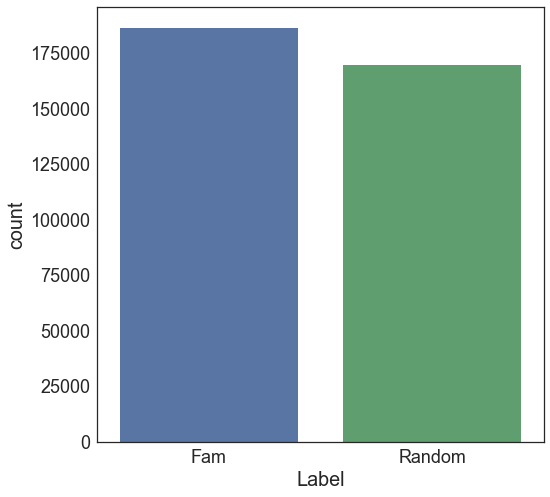

In [6]:
family_data = data[data['Label'].isin(['Fam', 'Random'])].copy()

fig, ax = plt.subplots(1, 1, figsize=(8,8))
sns.countplot(data=family_data, x='Label', ax=ax)

# Training-test split

Data is balanced so don't need to worry about any imbalance.

Important that we decide train/test sets before we go any further. We adopt an 80/20 split. Note below that we sample a subset (5000) of the total number of proteins (10251). Also note that we're splitting *by target* rather than simply splitting the examples. This ensures that all examples for a target are in the same set.

Also, for reproducibility, we set the seed for our random number generator.

In [7]:
np.random.seed(42)
n_samples = 5000

sample = np.random.choice(family_data['Target'].unique(), size=n_samples, replace=False)

n_train = int(0.8*n_samples)
n_test = int(0.2*n_samples)

train = sample[:n_train]
test = sample[n_train:]

In [8]:
feature_names = ['Target_Length', 'Template_Length', 'Contact_PPV', 'Contact_TP', 'Contact_P', 'Contact_All', 'Neff', 'SeqID']

train_idx = family_data['Target'].isin(train)
test_idx = family_data['Target'].isin(test)

X_train = family_data[train_idx][feature_names].values
X_test = family_data[test_idx][feature_names].values

y_train = family_data[train_idx]['Label'].replace({'Random': 0, 'Fam': 1}).values
y_test = family_data[test_idx]['Label'].replace({'Random': 0, 'Fam': 1}).values

Confirm that our training and test sets all have a similar balance of positive and negative examples.

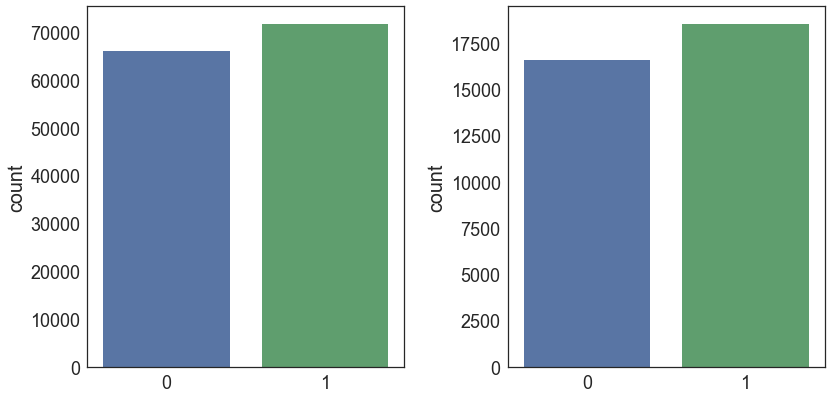

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.countplot(x=y_train, ax=axes[0])
sns.countplot(x=y_test, ax=axes[1])
fig.tight_layout()

# Training a random forest classifier

In [10]:
rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [11]:
print(f'Accuracy score: {rf.score(X_test, y_test):.3f}')

Accuracy score: 0.880


# Visualising the results

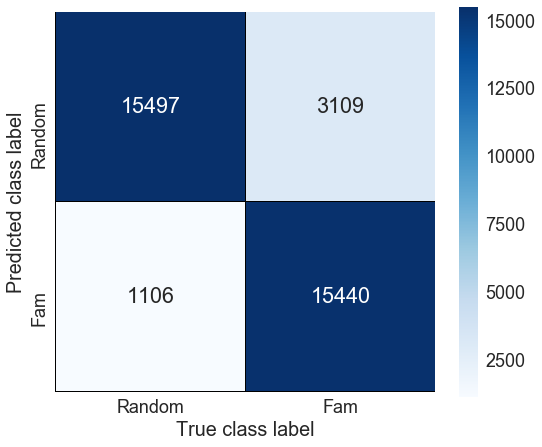

In [12]:
predicted = rf.predict(X_test)

fig, ax = plt.subplots(figsize=(8,8))
plotting.draw_confusion_matrix(y_test, predicted, ['Random', 'Fam'], ax=ax)
fig.tight_layout()

fig.savefig('rf_confusion_matrix.png')

In [13]:
# this will initially be absent
# show cm/roc curve, then ask "what if we want to try another classifier and compare it to our random forest?"
# illustrates how we can add a new cell anywhere and update our plots as we go along

logistic = LogisticRegression(C=1e5, random_state=42)
logistic.fit(X_train, y_train)
print(f'Accuracy score: {logistic.score(X_test, y_test):.3f}')

Accuracy score: 0.848


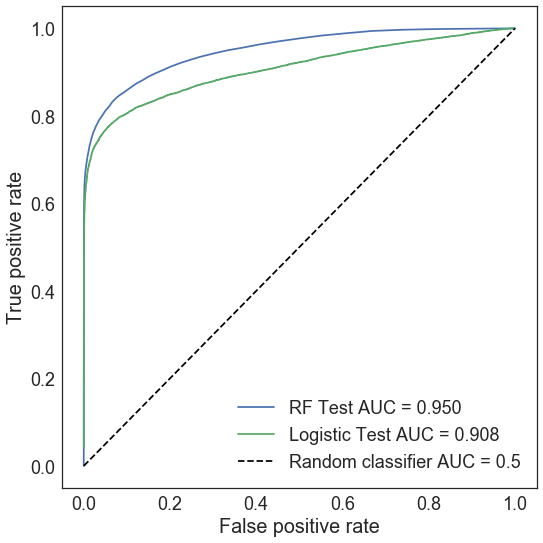

In [16]:
test_probs = rf.predict_proba(X_test)[:,1]

# initially absent
logistic_test_probs = logistic.predict_proba(X_test)[:,1]

# initially don't show result of testing on the training set
#train_probs = rf.predict_proba(X_train)[:,1]

fig, ax = plt.subplots(figsize=(8,8))
plotting.draw_roc_curve(y_test, test_probs, name='RF Test', ax=ax)
plotting.draw_roc_curve(y_test, logistic_test_probs, name='Logistic Test', ax=ax)
#plotting.draw_roc_curve(y_train, train_probs, name='RF Train', ax=ax)
ax.plot([0,1],[0,1], 'k--', label='Random classifier AUC = 0.5')
ax.legend(loc='best')
fig.tight_layout()

fig.savefig('roc_curve.png')